In [117]:
import pandas as pd
from importlib import reload

## Configs

In [118]:
BATCH_SIZE = 32
LEARNING_RATE = 5e-4

## Preprocessing
Negative Sampling the dataset

In [119]:
# from src.Preprocess.Preprocessor import Preprocessor
# Preprocessor.create_negative_sampled_dataset(input_address="data/SA_history_clicks_of_98.csv", 
#                                                output_address="data/data1.pkl", 
#                                                neg_to_pos_ratio=1)

## DatasetHandler
Preparing dataset for training

In [141]:
from src.Trainer.DatasetHandler import DatasetHandler

dataset_handler = DatasetHandler("data/data1.pkl", frac=0.01)
# dataset_handler = DatasetHandler("data/data1.pkl")

Loading tokenizer...
Reading input file...



Shuffling dataset...
Tokenizing ads...


C:\Users\Mohsen\Anaconda3\lib\site-packages\tqdm\std.py:654: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



Creating dataset...
Tokenizing queries...



Done


In [142]:
import pandas as pd
print(dataset_handler.get_dataset())
dataset_handler.df
pd.DataFrame(dataset_handler.get_dataset()["train"][:1000])

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'attention_mask', 'input_ids', 'packageName', 'package_ids', 'queryText', 'similar', 'token_type_ids'],
        num_rows: 186119
    })
    test: Dataset({
        features: ['__index_level_0__', 'attention_mask', 'input_ids', 'packageName', 'package_ids', 'queryText', 'similar', 'token_type_ids'],
        num_rows: 32845
    })
})


,__index_level_0__,attention_mask,input_ids,packageName,package_ids,queryText,similar,token_type_ids
0,48736,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[2, 10478, 2061, 2073, 50612, 8837, 7202, 3794...",com.siminalipor9.scanwifi,[88670],هکون برای دانلد وای فای خونگی,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,34465,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0]","[2, 2385, 2417, 8216, 2686, 4203, 4, 0, 0, 0]",boma.boma.app,[73406],برنامه جدید خاموش کردن صفحه,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,6085,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0]","[2, 29341, 43729, 4, 0, 0, 0, 0, 0, 0]",ir.farazroid.LastDic,[89806],speed test,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,182420,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]","[2, 36241, 4, 0, 0, 0, 0, 0, 0, 0]",com.google.android.apps.docs,[53922],drive,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,207816,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]","[2, 8468, 6896, 7849, 4, 0, 0, 0, 0, 0]",com.gisum.Story,[73148],قصه توت فرنگی,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...
995,117849,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0]","[2, 21050, 1154, 4, 0, 0, 0, 0, 0, 0]",ir.resaneh1.iptv,[59084],روبینو,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
996,85508,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0]","[2, 45484, 30777, 4, 0, 0, 0, 0, 0, 0]",ir.shabihsazsantooor.niva,[2376],lord king,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
997,180133,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0]","[2, 51611, 1200, 4, 0, 0, 0, 0, 0, 0]",com.appsaz.wito138909,[83306],wito,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
998,148664,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]","[2, 22003, 8977, 10657, 4, 0, 0, 0, 0, 0]",ir.hamiiid.desr,[79053],دسر پان اسپانیایی,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


## Training

Train on 186119 samples, test on 32845 samples
----------------



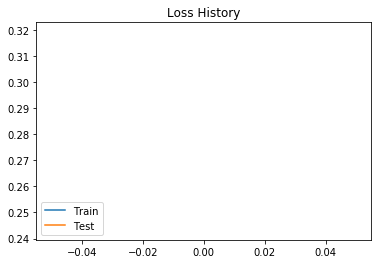

----------------



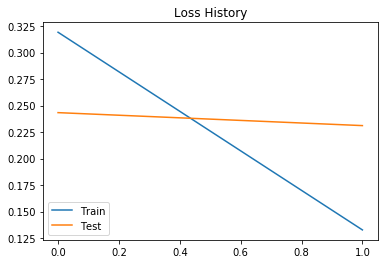

----------------



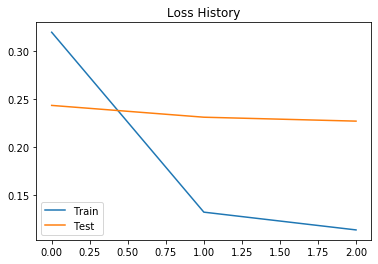

In [150]:
import src.Trainer.RepresentationBuilder
reload(src.Trainer.RepresentationBuilder)
import src.Trainer.QueryAdCoordinator
reload(src.Trainer.QueryAdCoordinator)
import src.Trainer.Trainer
reload(src.Trainer.Trainer)

trainer = src.Trainer.Trainer.Trainer(embedding_dim=50, dataset_handler=dataset_handler, learning_rate=LEARNING_RATE)
trainer.train(epochs=3)

In [151]:
trainer.query_ad_coordinator

QueryAdCoordinator(
  (query_representation_builder): RepresentationBuilder(
    (embedding): Embedding(100000, 50)
    (pooling_module): SpanPoolingAvg()
  )
  (ad_representation_builder): RepresentationBuilder(
    (embedding): Embedding(93592, 50)
    (pooling_module): SpanPoolingAvg()
  )
  (loss): CosineEmbeddingLoss()
)

In [152]:
trainer.save_all_representations(ad_reprs_address="representations/ad_reprs.pt",
                                    vocab_reprs_address="representations/vocab_reprs.pt",
                                    id_to_package_address="representations/ad_id_to_package.pkl")


100000
Saved vocab representations at representations/vocab_reprs.pt



torch.Size([93592, 50])
Saved ad representations at representations/ad_reprs.pt


## Prediction

In [153]:
import src.Predictor.Predictor
reload(src.Predictor.Predictor)

predictor = src.Predictor.Predictor.Predictor(ad_reprs_address="representations/ad_reprs.pt",
                                              vocab_reprs_address="representations/vocab_reprs.pt",
                                              id_to_package_address="representations/ad_id_to_package.pkl")

Loading tokenizer...
Loading ad representations...
Loading ad id to package...
Loading vocab representations...


In [156]:
predictor.predict_from_query("زامبی", full_results=True)

dist: 0.99375 com.gameresort.stupidzombies
dist: 0.99288 com.ea.game.pvzfree_row
dist: 0.99053 net.mobigame.zombietsunami
dist: 0.98826 com.feelingtouch.zf3d.farsi
dist: 0.98741 com.auxbrain.zombie_highway
dist: 0.98501 com.JESoftware.LastHopeSniperWar
dist: 0.98263 com.mobirix.archerybigm
dist: 0.98231 com.feelingtouch.gunzombie
dist: 0.98213 com.ata13.bentenozambiha
dist: 0.98160 air.com.noxgames.PuppetSoccer2014


(['com.gameresort.stupidzombies',
  'com.ea.game.pvzfree_row',
  'net.mobigame.zombietsunami',
  'com.feelingtouch.zf3d.farsi',
  'com.auxbrain.zombie_highway',
  'com.JESoftware.LastHopeSniperWar',
  'com.mobirix.archerybigm',
  'com.feelingtouch.gunzombie',
  'com.ata13.bentenozambiha',
  'air.com.noxgames.PuppetSoccer2014'],
 tensor([0.9937, 0.9929, 0.9905, 0.9883, 0.9874, 0.9850, 0.9826, 0.9823, 0.9821,
         0.9816], grad_fn=<TopkBackward>),
 tensor([46879, 26955,  8551, 88091, 26896, 77809, 53234, 40365, 62230, 74315]),
 tensor([[-7.2075,  9.3107, -4.1622,  8.9597,  5.3871, -4.2872, -9.3045, -8.3343,
           9.9126, -3.9416, -9.5004, -9.0008,  9.2402,  6.5209,  3.2705,  8.9672,
           8.8820,  7.5313, -8.2822,  9.8963,  9.0271, -7.6464, -9.0956, -1.6164,
          -8.1645,  9.2530,  9.3118,  9.2691,  9.2607,  8.6454,  7.4114, -9.8200,
          -9.7260, -4.3635, -9.9595,  8.9240,  9.8537,  8.9483, -8.0638, 10.4727,
           7.9378, -8.6774, 10.0358,  9.2991,  7.9228, 

### TSNE

dist: 0.99375 com.gameresort.stupidzombies
dist: 0.99288 com.ea.game.pvzfree_row
dist: 0.99053 net.mobigame.zombietsunami
dist: 0.98826 com.feelingtouch.zf3d.farsi
dist: 0.98741 com.auxbrain.zombie_highway
dist: 0.98501 com.JESoftware.LastHopeSniperWar
dist: 0.98263 com.mobirix.archerybigm
dist: 0.98231 com.feelingtouch.gunzombie
dist: 0.98213 com.ata13.bentenozambiha
dist: 0.98160 air.com.noxgames.PuppetSoccer2014
dist: 0.98150 com.avast.android.mobilesecurity
dist: 0.98149 mhn.zambi
dist: 0.98138 com.radarcustomer
dist: 0.98135 com.aparat
dist: 0.98135 com.outfit7.mytalkinghank
dist: 0.98114 com.mobiliha.badesaba
dist: 0.98106 com.instagram.android
dist: 0.98065 com.calfordcn.gu
dist: 0.98064 com.aa.extreme.city.gt.car.stunts
dist: 0.98062 com.fantasticgs.GG


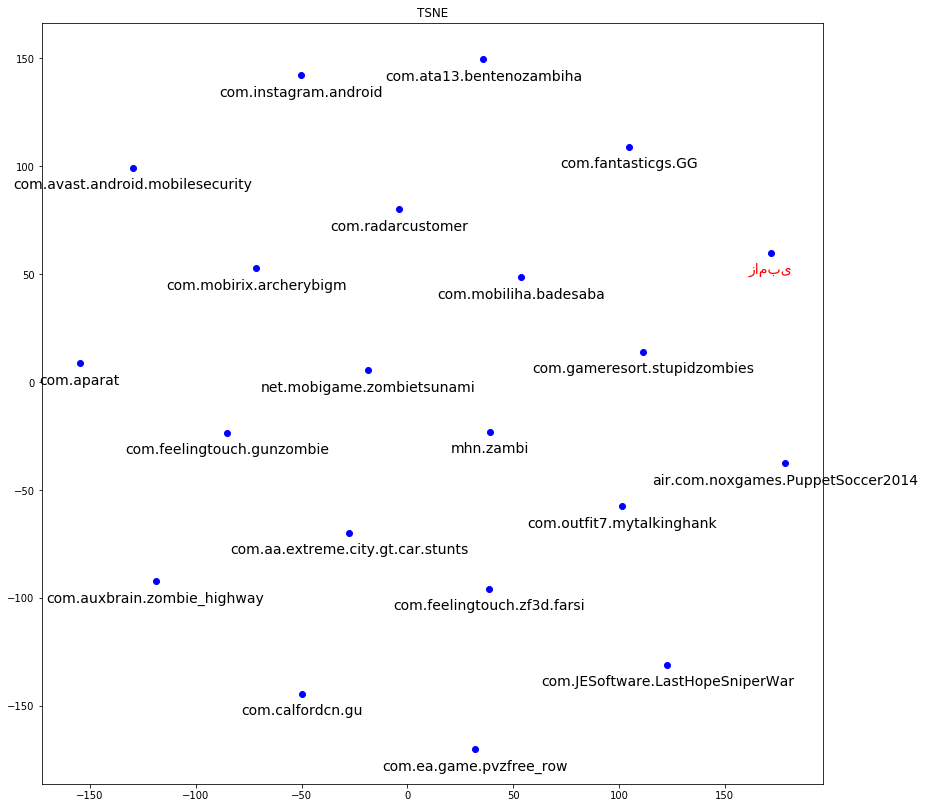

In [157]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

top_k = 20
query = "زامبی"

packages, knn_values, knn_ids, query_repr = predictor.predict_from_query(query, full_results=True, k=top_k)

reprs = torch.cat((predictor.ad_reprs[knn_ids], query_repr), dim=0).detach().numpy()

id_to_name = []
for idx in knn_ids:
    id_to_name.append(predictor.ad_id_to_package[int(idx)])
id_to_name.append(query)

tsne = TSNE(metric='cosine', random_state=123)
embed_tsne = tsne.fit_transform(reprs)
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(top_k + 1):
    plt.scatter(*embed_tsne[idx, :], color='blue')
    plt.title("TSNE")
    if idx == top_k:
        color = "red"
    else:
        color = "black"
    plt.annotate(id_to_name[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), 
                 alpha=1, color=color, fontsize=14, xytext=(0, -10), va='top', ha='center', textcoords='offset points')
